### Dataset

Download the 2D OASIS-3 dataset from:

https://drive.google.com/drive/folders/1hzqyOthgmOmwJiMvexMjv3QJ5kgKnBcY?usp=drive_link

Update the ```dataset_root``` variable below to point to the 2D dataset on your system.

In [1]:
%load_ext autoreload
%autoreload 2

dataset_root = "/mnt/f/OASIS-3-MR-Sessions-2D/"

In [4]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.data import decollate_batch, DataLoader, CacheDataset, ThreadDataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    EnsureTyped,
    Resized,
    CropForegroundd,
    SpatialPadd,
    CastToTyped,
    ConcatItemsd,
)
from monai.utils import set_determinism

In [5]:
import pandas as pd
import os 
from enum import Enum
from monai.transforms import Transform

modality_names = ["MR T1w", "MR T2w", "MR T2*", "MR FLAIR", "MR TOF-MRA"]

def create_oasis_3_multimodal_dataset(csv_path: str, dataset_root: str, transform: Transform, cache_rate: float):
    train_df = pd.read_csv(csv_path, sep=";")
    train_df.fillna('', inplace=True)

    train_data = []
    for index, row in train_df.iterrows():
        data_dict = {}
        has_non_empty = False
        for modality in modality_names:
            file_path = row[modality]
            if file_path:
                has_non_empty = True
                data_dict[modality] = os.path.join(dataset_root, file_path)
            else:
                data_dict[modality] = "empty_volume_2d.nii.gz"
        if not has_non_empty:
            continue
        data_dict["label"] = row["label"]
        train_data.append(data_dict)
    return CacheDataset(data=train_data, transform=transform, cache_rate=cache_rate, num_workers=5, copy_cache=False)

class SafeCropForegroundd:
    def __init__(self, keys, source_key, select_fn, margin=0):
        self.source_key = source_key
        self.crop_foreground = CropForegroundd(keys=keys, source_key=source_key, select_fn=select_fn, margin=margin)

    def __call__(self, data):
        cropped_data = self.crop_foreground(data.copy())
        cropped_image = cropped_data[self.source_key]

        # Check if any dimension (excluding batch and channel dimensions) is zero.
        if np.any(np.asarray(cropped_image.shape[1:]) == 0):
            return data  # Revert to original data if cropped size is zero in any dimension
        
        return cropped_data

In [6]:
resolution = 256
cache_rate = 1.0 # might need to change this based on the amount of memory available
batch_size = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
foreground_crop_threshold = 0.1
transform_list = [
        LoadImaged(keys=modality_names, image_only=True),
        EnsureChannelFirstd(keys=modality_names + ["label"], channel_dim="no_channel"),
        CastToTyped("label", dtype=np.float64),
        ScaleIntensityd(keys=modality_names),
    ]
for i in range(len(modality_names)):
     transform_list.append(
         SafeCropForegroundd(keys=modality_names[i], source_key=modality_names[i], select_fn=lambda x: x > foreground_crop_threshold, margin=5)
     )
transform_list.extend([
    Resized(keys=modality_names, spatial_size=resolution, size_mode="longest"),
    SpatialPadd(keys=modality_names, spatial_size=(resolution, resolution)),
    ConcatItemsd(keys=modality_names, name="image"),
    EnsureTyped(keys=["image"], device=device),
]
)
transform = Compose(transform_list)

train_table_path = "csv/oasis/oasis_3_multimodal_train.csv"
train_ds = create_oasis_3_multimodal_dataset(csv_path=train_table_path, dataset_root=dataset_root, transform=transform, cache_rate=cache_rate)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=batch_size, shuffle=True)

val_table_path = "csv/oasis/oasis_3_multimodal_val.csv"
val_ds = create_oasis_3_multimodal_dataset(csv_path=val_table_path, dataset_root=dataset_root, transform=transform, cache_rate=cache_rate)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=batch_size, shuffle=True)

Loading dataset: 100%|██████████| 284/284 [00:23<00:00, 12.11it/s]


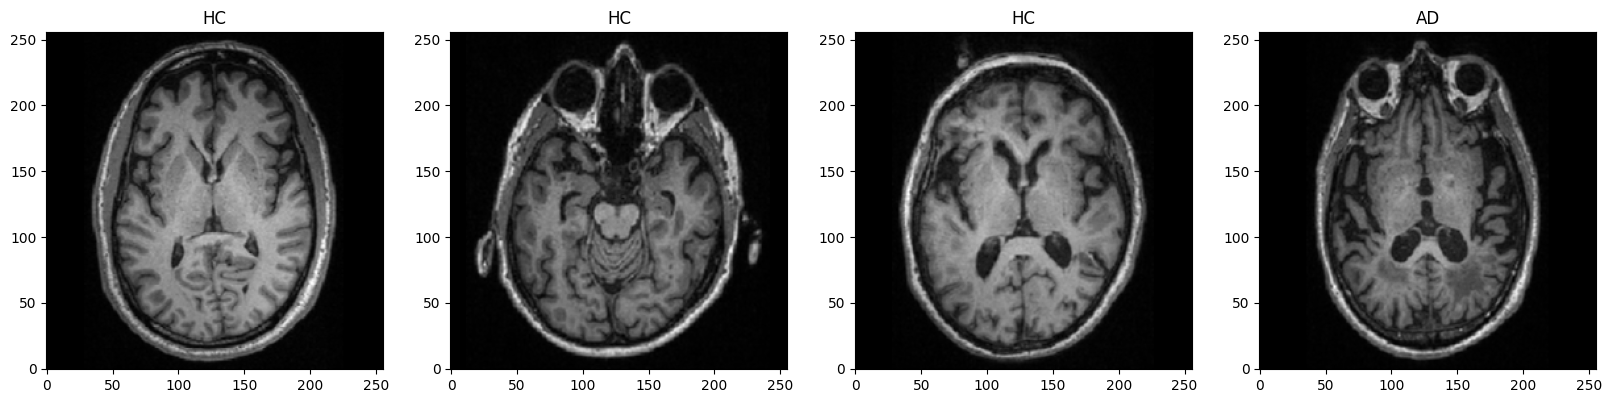

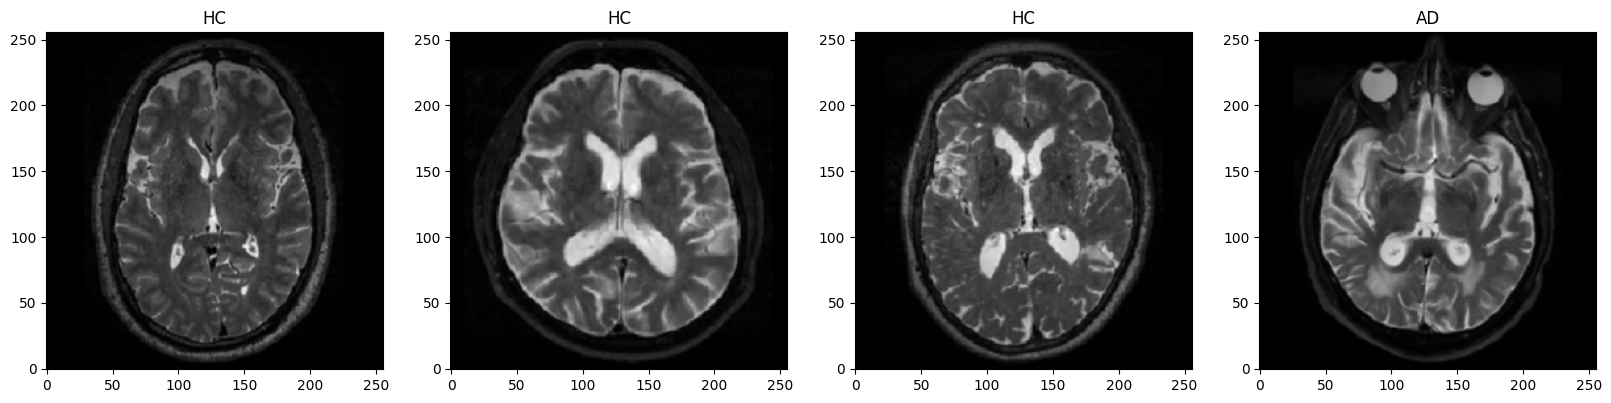

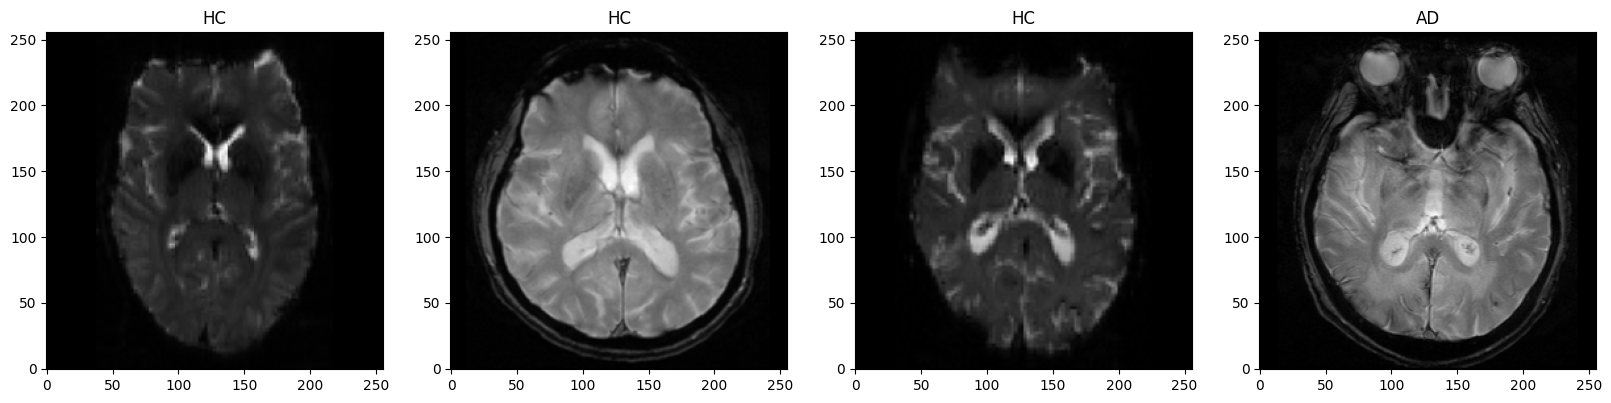

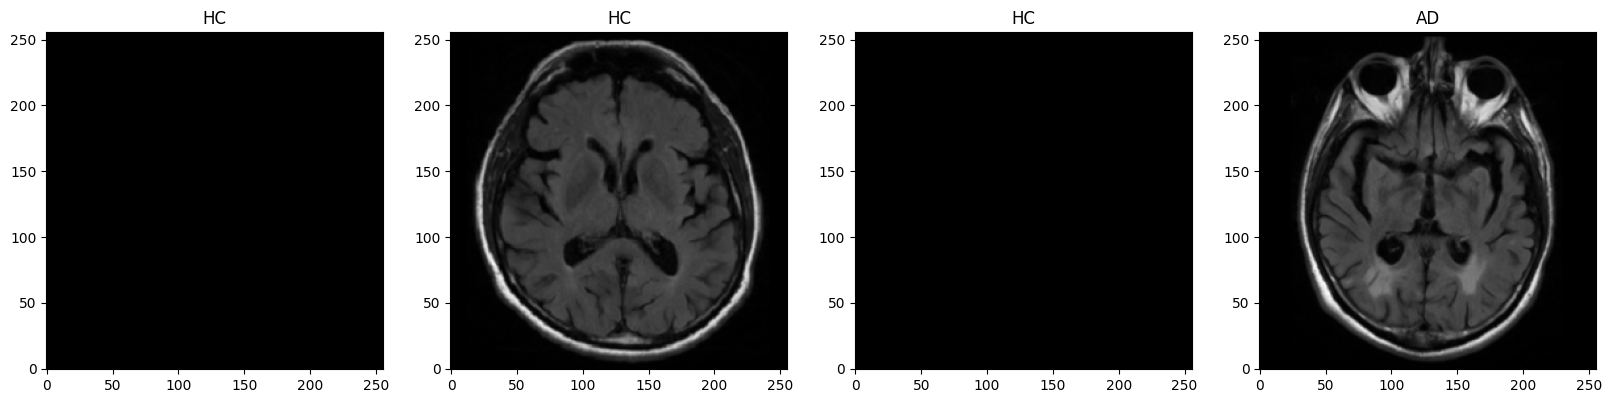

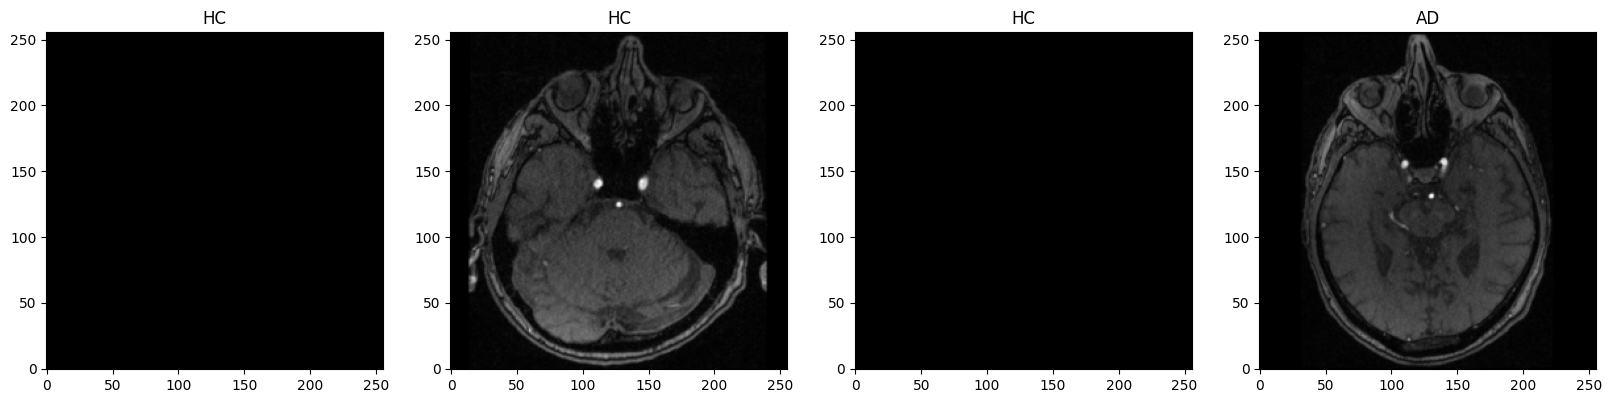

In [24]:
dataiter = iter(train_loader)
batch_sample = next(dataiter)
images = batch_sample["image"]
labels = batch_sample["label"]

classes = ["HC", "AD"]

plt.figure(figsize=(20, 12))
i = 0
for sample_data, sample_label in zip(images, labels):
    sample = sample_data.cpu()[0]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(sample.T, cmap='gray', origin='lower')
    plt.title(f"{classes[int(sample_label.cpu()[0])]}")  # Display the label as the title
    i += 1
plt.show()

plt.figure(figsize=(20, 12))
i = 0
for sample_data, sample_label in zip(images, labels):
    sample = sample_data.cpu()[1]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(sample.T, cmap='gray', origin='lower')
    plt.title(f"{classes[int(sample_label.cpu()[0])]}")  # Display the label as the title
    i += 1
plt.show()

plt.figure(figsize=(20, 12))
i = 0
for sample_data, sample_label in zip(images, labels):
    sample = sample_data.cpu()[2]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(sample.T, cmap='gray', origin='lower')
    plt.title(f"{classes[int(sample_label.cpu()[0])]}")  # Display the label as the title
    i += 1
plt.show()

plt.figure(figsize=(20, 12))
i = 0
for sample_data, sample_label in zip(images, labels):
    sample = sample_data.cpu()[3]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(sample.T, cmap='gray', origin='lower')
    plt.title(f"{classes[int(sample_label.cpu()[0])]}")  # Display the label as the title
    i += 1
plt.show()

plt.figure(figsize=(20, 12))
i = 0
for sample_data, sample_label in zip(images, labels):
    sample = sample_data.cpu()[4]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(sample.T, cmap='gray', origin='lower')
    plt.title(f"{classes[int(sample_label.cpu()[0])]}")  # Display the label as the title
    i += 1
plt.show()

### Define network and optimizer

In [37]:
model = DenseNet121(spatial_dims=2, in_channels=len(modality_names), out_channels=1).to(device)
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
scaler = torch.cuda.amp.GradScaler()
max_epochs = 8
val_interval = 1
auc_metric = ROCAUCMetric()
out_model_dir = "./pretrained/"
model_file_name = f"DenseNet121_ad_cls_oasis_3.pth"
model_file_name

'DenseNet121_ad_cls_oasis_3.pth'

### Training

In [38]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

y_pred_trans = Compose([Activations(sigmoid=True)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = torch.cat([i for i in decollate_batch(y, detach=False)], dim=0)
            y_pred_act = torch.cat([y_pred_trans(i) for i in decollate_batch(y_pred)], dim=0)
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            metric_values.append(result)
            acc_value = torch.eq((y_pred_act > 0.5).long(), y)
            acc_metric = acc_value.float().mean().item()
            del y_pred_act, y_onehot
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(out_model_dir, model_file_name))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric (AUC): {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/8
1/639, train_loss: 0.6536
2/639, train_loss: 0.6581
3/639, train_loss: 0.6448
4/639, train_loss: 0.7067
5/639, train_loss: 0.6615
6/639, train_loss: 0.6117
7/639, train_loss: 0.6087
8/639, train_loss: 0.6028
9/639, train_loss: 0.6085
10/639, train_loss: 0.6029
11/639, train_loss: 0.6419
12/639, train_loss: 0.6922
13/639, train_loss: 0.7101
14/639, train_loss: 0.5944
15/639, train_loss: 0.6029
16/639, train_loss: 0.5980
17/639, train_loss: 0.6511
18/639, train_loss: 0.6316
19/639, train_loss: 0.5818
20/639, train_loss: 0.6091
21/639, train_loss: 0.6965
22/639, train_loss: 0.6837
23/639, train_loss: 0.5821
24/639, train_loss: 0.5831
25/639, train_loss: 0.7081
26/639, train_loss: 0.5750
27/639, train_loss: 0.5746
28/639, train_loss: 0.7158
29/639, train_loss: 0.6929
30/639, train_loss: 0.6532
31/639, train_loss: 0.5693
32/639, train_loss: 0.6124
33/639, train_loss: 0.5632
34/639, train_loss: 0.5605
35/639, train_loss: 0.5625
36/639, train_loss: 0.5634
37/639, train_lo

KeyboardInterrupt: 